In [1]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import reduce_mem_usage

from probspace_usstock.modules.config_manager import ConfigManager
from probspace_usstock.modules.features import (
    create_company_features,
    calc_Symbol_lag_features,
    # calc_List_lag_features,
    create_ymd_features
)
from probspace_usstock.modules.preprocessor import (
    melt_dataframe,
    create_base_dataframe
)
from probspace_usstock.modules.train_module import TrainLGBModule
from probspace_usstock.modules.predict import make_pred_df

sys.path.append("../")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# read
df_train_origin = pd.read_csv("../input/train_data.csv", encoding="utf-8-sig")
df_company_list_origin = pd.read_csv("../input/company_list.csv", encoding="utf-8-sig")
df_sub_template = pd.read_csv("../input/submission_template.csv", encoding="utf-8-sig")

# shape
display(df_train_origin.shape)
display(df_company_list_origin.shape)
display(df_sub_template.shape)

(420, 3279)

(7007, 6)

(3278, 2)

In [3]:
print("■train_data")
display(df_train_origin.shape)
display(df_train_origin.head(4))

print("■company_list")
display(df_company_list_origin.shape)
display(df_company_list_origin.head(1))

print("■submission_template")
display(df_sub_template.shape)
display(df_sub_template.head(1))

■train_data


(420, 3279)

,Date,VGSH,JEF,IVZ,KTCC,FBZ,PLOW,JBK,IAC,IVR,VSH,VCV,OKE,ROK,FTAG,BRKR,GSK,JPS,SRPT,VMI,IMKTA,BDR,JAKK,MVC,AMSF,APTO,CNX,XOMA,LBY,BIOL,PAAS,KOF,LAC,EML,IVC,TILE,IEF,CSV,QADA,TBNK,HOG,WIW,SVBI,PKOH,CREG,LOGM,ERII,PEBO,PEER,ORA,RIO,BPOPM,PDLI,RYN,UNAM,PFD,CALX,SNSS,TCF,MTRX,AVGO,MSM,REV,HSY,PEP,REED,HPQ,BKTI,MPB,AAON,PSO,CIG,NAC,OPNT,RE,SES,RTN,WST,HIHO,FLC,EFT,DCI,IIF,BANC,CRS,GAIN,UHT,TMO,MFNC,TEX,LTBR,QGEN,EVV,BBY,MRKR,CSQ,KBAL,QRHC,ANIP,FMBH,...,CONN,EGO,CY,ICLN,NNVC,AIZ,XAN,ALIM,PFL,WIA,TRST,EXD,HNW,SBLK,AUBN,GSIT,ISSC,ESGR,CAMT,CKH,CLS,ZTR,SIRI,PFM,ANTE,PZC,DSLV,WDC,PRPH,RS,BOTJ,CE,HAIN,QCLN,ATR,WSM,LNG,VTWO,FRC,FUL,ICFI,CIZN,UFI,MXIM,MRLN,GTT,CR,SXT,NBTB,ADI,EVK,WSBC,ACER,CHN,CORT,FLIC,ADTN,PFLT,AVID,TSEM,KRO,MORN,BHV,MMU,SGRP,PBA,GF,OSPN,J,AMKR,CPHI,TRT,OPRX,DXYN,GFED,FRAF,HWCC,WYND,CHMG,EVC,NNA,IOR,ATLC,STWD,TTM,NOC,EQS,MKC,MXL,NEV,ASFI,JTA,MNR,TFSL,GTN,TYG,VIRC,BIS,WOOD,MASI
0,2011/11/13,55.942184,17.649006,13.770864,4.77,13.818835,10.198389,12.440549,38.484608,4.836254,8.575465,7.877108,23.100210,59.334507,84.253273,11.731660,28.273636,4.168243,4.86,75.028809,12.110400,1.13,18.456266,7.713052,15.194721,2.88,29.963728,30.400000,10.973586,14.384466,20.405405,73.412354,1.75,16.415005,19.071070,10.358725,88.829475,5.339281,10.804994,15.035470,29.228592,9.278417,2.594832,17.814543,14.5,38.607750,2.50,9.508274,22.400000,17.544151,34.077663,9.051845,4.036423,21.052782,10.179731,7.213885,8.41,7.50,14.216700,9.68,24.646343,50.906437,14.46,46.303482,49.788853,1.39,8.927394,0.877275,6.139855,8.682248,12.204165,3.919564,8.690806,0.42,73.116982,98.559998,35.922192,17.122187,1.637933,9.453785,8.308208,28.895016,9.979239,8.690458,45.424389,3.396492,23.906984,44.114647,3.987525,13.897991,187.800003,13.728254,7.737930,21.358797,288.0,4.088526,3.683195,18.000000,84.599998,14.962660,...,9.95,83.039902,13.923010,7.072347,55.299999,31.703871,11.661029,1.29,4.546225,9.558780,3.620234,7.187960,8.973720,84.834564,14.881336,4.86,3.010909,96.360001,1.812006,58.838348,8.25,4.215335,1.700923,11.964488,14.300000,5.702804,43.799999,20.713301,0.762946,36.546154,4.475960,35.595501,17.670000,9.581954,42.146973,29.780903,11.70,51.195068,22.606068,20.090033,24.530502,11.557922,7.89,19.594046,8.667803,1.36,38.136402,30.210152,15.731730,28.358801,1.37,15.125630,373.333344,10.369422,3.39,9.227671,27.211815,5.037442,7.10,10.65,12.701912,53.690952,13.001904,8.411827,1.22,16.457903,6.239215,8.04,39.470684,4.63,0.88,2.40,3.06,2.93,4.992733,10.988591,9.748321,10.293147,17.453051,1.078169,33.496590,1.92,3.16,6.810544,15.831424,47.542465,2.21,40.948685,4.96,8.450615,3.721562,4.747546,5.567790,7.262252,1.80,20.079035,1.504111,826.767029,30.918266,18.430309
1,2011/11/20,55.978844,16.270664,12.719761,4.94,12.744166,10.035272,12.065370,36.252533,4.658076,7.657301,7.939425,22.540537,55.720310,78.528595,11.262002,27.104542,4.072667,4.08,69.938858,11.282884,1.14,17.461733,6.991731,14.490328,2.52,27.630514,30.799999,10.061356,12.466537,20.022963,68.245247,1.65,16.306412,18.346851,8.876307,89.084717,5.274280,9.564995,14.278780,27.989960,9.314977,2.662356,15.294662,12.5,34.829571,2.27,7.991528,22.400000,15.904687,30.586075,9.023554,4.063376,19.843987,10.206950,7.154890,7.18,6.90,12.750013,8.53,23.474276,48.047035,13.74,45.746265,48.697853,1.40,8.098125,0.919861,6.164315,7.810735,11.651024,3.674882,8.618720,0.40,69.981857,89.599998,35.203728,16.185606,1.494254,9.253301,8.163390,27.018999,9.378841,7.772503,41.059013,3.186542,22.347122,42.692211,4.068903,11.817956,160.800003,13.438292,7.711720,20.230078,264.0,3.903125,3.333358,19.600000,79.919998,15.667272,...,10.10,79.030418,12.645804,6.734447,49.700001,30.477777,11.191008,1.19,4.488735,9.543862,3.398002,7.272264,8.764602,84.780708,14.881336,4.69,2.892424,91.690002,1.634359,56.146488,7.54,4.132953,1.672256,11.491554,15.050000,5.714909,47.240002,19.886042,0.835607,35.020405,3.670286,35.281651,17.620001,8.790443,40.813152,28.370873,10.21,47.593803,21.723381,18.736162,23.587021,11.517131,7.39,18.258261,7.567554,1.30,36.288921,

■company_list


(7007, 6)

,Symbol,Name,IPOyear,Sector,Industry,List
0,XXII,"22nd Century Group, Inc",NaN,Consumer Non-Durables,Farming/Seeds/Milling,AMEX


■submission_template


(3278, 2)

,id,y
0,VGSH,NaN


## baseとなるdataframeを作成する

In [13]:
config_path = "../config/setting.yaml"
config_manager = ConfigManager(config_path=config_path)

In [5]:
# company関連の特徴量を先に作ってListをマージしたい
df_company_features = create_company_features(
    input=df_company_list_origin,
    duplicate_companies=config_manager.duplicate_companies
)
display(df_company_features.head(2))
display(df_company_features.shape)

,Symbol,IPOyear,Sector,List
0,XXII,NaN,Consumer Non-Durables,AMEX
1,FAX,1986.0,NaN,AMEX


(6991, 4)

In [6]:
df_base = melt_dataframe(input=df_train_origin)
df_base = create_base_dataframe(input=df_base, df_company=df_company_features)

display(df_base.head(2))

,Date,Symbol,List,stock_price
0,2011/11/13,VGSH,NASDAQ,55.942184
1,2011/11/20,VGSH,NASDAQ,55.978844


## 特徴量作成

In [7]:
%%time

df_ymd = create_ymd_features(input=df_base)
df_Symbol_lag = calc_Symbol_lag_features(input=df_base)
# df_List_lag = reduce_mem_usage(calc_List_lag_features(input=df_Symbol_lag))

display(df_ymd.head(2))
display(df_Symbol_lag.head(2))
# display(df_List_lag.head(2))

,Date,year,month,day,week_of_month,week_of_year
0,2011/11/13,2011,11,13,2,45
1,2011/11/20,2011,11,20,3,46


,Date,Symbol,stock_price_1s,stock_price_2s,stock_price_3s,stock_price_4s,increase_stock_price_1s2s,increase_stock_price_2s3s,increase_stock_price_3s4s,stock_price_1s_4r_mean,stock_price_1s_4r_median,stock_price_1s_4r_max,stock_price_1s_4r_min,stock_price_1s_8r_mean,stock_price_1s_8r_median,stock_price_1s_8r_max,stock_price_1s_8r_min,stock_price_1s_12r_mean,stock_price_1s_12r_median,stock_price_1s_12r_max,stock_price_1s_12r_min
0,2011/11/13,VGSH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,55.942184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CPU times: user 1min 16s, sys: 1.17 s, total: 1min 17s
Wall time: 1min 19s


In [8]:
%%time

# _df_base = df_base[pd.to_datetime(df_base["Date"]) < pd.to_datetime("2013-01-01")].copy()

df_merge = pd.merge(df_base, df_company_features.drop("List", axis=1), how="left", on="Symbol")
df_merge = pd.merge(df_merge, df_ymd, how="left", on="Date")
df_merge = pd.merge(df_merge, df_Symbol_lag, how="left", on=["Date", "Symbol"])
# df = pd.merge(df, df_List_lag, how="left", on=["Date", "List"])

CPU times: user 1.02 s, sys: 331 ms, total: 1.35 s
Wall time: 1.36 s


In [9]:
df_merge.head()

,Date,Symbol,List,stock_price,IPOyear,Sector,year,month,day,week_of_month,week_of_year,stock_price_1s,stock_price_2s,stock_price_3s,stock_price_4s,increase_stock_price_1s2s,increase_stock_price_2s3s,increase_stock_price_3s4s,stock_price_1s_4r_mean,stock_price_1s_4r_median,stock_price_1s_4r_max,stock_price_1s_4r_min,stock_price_1s_8r_mean,stock_price_1s_8r_median,stock_price_1s_8r_max,stock_price_1s_8r_min,stock_price_1s_12r_mean,stock_price_1s_12r_median,stock_price_1s_12r_max,stock_price_1s_12r_min
0,2011/11/13,VGSH,NASDAQ,55.942184,NaN,NaN,2011,11,13,2,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/11/20,VGSH,NASDAQ,55.978844,NaN,NaN,2011,11,20,3,46,55.942184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/11/27,VGSH,NASDAQ,56.021038,NaN,NaN,2011,11,27,4,47,55.978844,55.942184,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/12/4,VGSH,NASDAQ,56.002697,NaN,NaN,2011,12,4,1,48,56.021038,55.978844,55.942184,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011/12/11,VGSH,NASDAQ,56.030224,NaN,NaN,2011,12,11,2,49,56.002697,56.021038,55.978844,55.942184,0.0,1.0,1.0,55.986191,55.99077,56.021038,55.942184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# NaNがある期間は学習に使用しない
df_merge = df_merge[df_merge["stock_price_1s_12r_mean"].notnull()]
df_merge = reduce_mem_usage(df_merge)
df_merge.info()

Memory usage of dataframe is 316.32 MB
Memory usage after optimization is: 79.25 MB
Decreased by 74.9%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337424 entries, 12 to 1376759
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Date                       1337424 non-null  category
 1   Symbol                     1337424 non-null  category
 2   List                       1335792 non-null  category
 3   stock_price                1334146 non-null  float16 
 4   IPOyear                    441864 non-null   float16 
 5   Sector                     1114656 non-null  category
 6   year                       1337424 non-null  int16   
 7   month                      1337424 non-null  int8    
 8   day                        1337424 non-null  int8    
 9   week_of_month              1337424 non-null  int8    
 10  week_of_year               1337424 non-null  int8    
 11  stock_price

## 学習

In [12]:
df_merge = format_df(df_merge, config_manager.feature_columns)

In [14]:
def split_dataframe(input: pd.DataFrame, config: Dict) -> pd.DataFrame:
    df_train = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.train_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.train_period[1]))
    ].copy()
    df_val = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.valid_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.valid_period[1]))
    ].copy()
    df_test = input[
        (pd.to_datetime(input["Date"]) >= pd.to_datetime(config.test_period[0])) &
        (pd.to_datetime(input["Date"]) <= pd.to_datetime(config.test_period[1]))
    ].copy()
    return df_train, df_val, df_test

df_train, df_val, df_test = split_dataframe(input=df_merge, config=config_manager)

In [27]:
def calc_lgb_weight(input: pd.DataFrame) -> pd.DataFrame:
    return 1 / input["stock_price_1s_4r_mean"].replace(0, 1) * 10

weight_train = calc_lgb_weight(df_train)
weight_val = calc_lgb_weight(df_val)

In [28]:
ins_train = TrainLGBModule(config=config_manager, target=config_manager.pred_cols)
trained_model, df_imp, evals_result = ins_train.train_model(
    df_train=df_train, df_val=df_val, have_weight=True, weight_train=weight_train, weight_val=weight_val)

Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.915139	valid_1's rmse: 1.24661
Early stopping, best iteration is:
[964]	training's rmse: 0.916697	valid_1's rmse: 1.24615


''

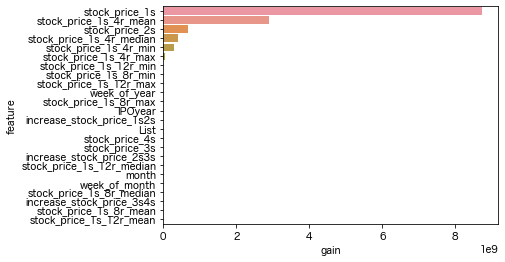

In [29]:
df_imp_ = df_imp.sort_values("gain", ascending=False)
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"])
;

In [30]:
df_test_pred = make_pred_df(
    model=trained_model,
    target=config_manager.pred_cols,
    df_test=df_test[config_manager.feature_columns.keys()],
    config=config_manager,
    is_test=True,
    cv_num=1
)
df_test_pred = pd.merge(
    df_test_pred,
    df_test[["Date", "Symbol", "stock_price"]],
    how="left",
    on=["Date", "Symbol"]
)

display(df_test_pred.head())
display(df_test_pred.shape)

pred stock_price ...


,Date,Symbol,cv_num,pred_stock_price,stock_price
0,2019/11/17,VGSH,1,60.611410,60.375000
1,2019/11/17,JEF,1,19.160021,20.640625
2,2019/11/17,IVZ,1,17.313894,17.046875
3,2019/11/17,KTCC,1,6.004173,5.519531
4,2019/11/17,FBZ,1,14.955699,14.765625


(6556, 5)

In [31]:
from sklearn.metrics import mean_squared_log_error

target_Date = "2019/11/17"

y_true = df_test_pred[df_test_pred["Date"] == target_Date]["stock_price"]
y_pred = df_test_pred[df_test_pred["Date"] == target_Date]["pred_stock_price"]

RMSLE=np.sqrt(mean_squared_log_error(y_true, y_pred))
print(RMSLE)

0.0556501716826904


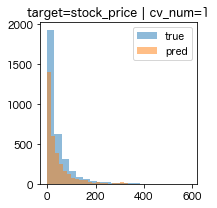

In [32]:
plot_histgram_for_valid(
    data_true=df_test_pred[df_test_pred["Date"] == target_Date]["stock_price"],
    data_pred=df_test_pred[df_test_pred["Date"] == target_Date]["pred_stock_price"],
    title=f"target=stock_price | cv_num=1",
    figsize=(3,3)
)

## 提出

In [33]:
submission_Date = "2019/11/24"

df_submission = df_test_pred[df_test_pred["Date"] == submission_Date][["Symbol", "pred_stock_price"]].copy()
df_submission = df_submission.rename(columns={"Symbol": "id", "pred_stock_price": "y"})
df_submission.to_csv("../output/submission_1.csv", index=False, encoding="utf-8-sig")